In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
# Accessing data
import os
cwd = os.getcwd() # 수정필요
print(cwd)

/content


In [ ]:
files = os.listdir(cwd)
filename = [file for file in files if file.endswith('.csv')]
trainingDataFile = filename
print(trainingDataFile)

[]


In [ ]:
label = [
         'NOxFlowRateValidTail'
]

features = [
            'calLoad',
            # 'coolantTemp',
            # 'intMAP',
            'engSpeed',
            'vehSpeed',
            'intAirTemp',
            'MAF',
            'absTPS',
            'fuelInjTiming',
            'EGT11',
            'EGT12',
            'fuelrailPress',
            'baroPress',
            'catTemp',
            'voltage',
            'ambTemp',
            # 'accPedalD',
            # 'accPedalE',
            'fuelRate',
            'actEngPerTorque',
            'MAFSensor',
            'compressorInletTemp',
            'exhFlowrate',
            'O2RawSensor1_2',
            'CO2FlowRate',
            'slope_engSpeed',
            'slope_calLoad',
            'slope_EGT',
            'slope_CO2',
            'slope_O2',
            # 'slope_compressorInletTemp',
            # 'slope_MAF',
            'slope_actEngPerTorque',
            'slope_fuelRate',
            'slope_fuelrailPressure',
            'slope_exhFlowrate',
            # 'NOxRawSensor1_2',
            'NOxFlowRateValidTail'
]
print(len(features))

29


In [ ]:
full_data = []
i = 0

for filename in trainingDataFile:
    file_path = os.path.join(cwd,filename)
    load_data = pd.read_csv(file_path, usecols=features)
    if i == 0:
        full_data = load_data
    else:
        full_data = full_data.append(load_data, ignore_index=True, sort=False)
    i += 1

In [ ]:
full_data.shape

(83407, 29)

In [ ]:
full_data.head()

,calLoad,engSpeed,vehSpeed,intAirTemp,MAF,absTPS,fuelrailPress,baroPress,catTemp,voltage,ambTemp,fuelInjTiming,fuelRate,actEngPerTorque,MAFSensor,compressorInletTemp,EGT11,EGT12,NOxRawSensor1_2,O2RawSensor1_2,exhFlowrate,CO2FlowRate,NOxFlowRateValidTail,slope_engSpeed,slope_O2,slope_MAF,slope_actEngPerTorque,slope_fuelRate,slope_exhFlowrate
0,0.0,0.0,0.0,24.0,0.0,0.0,450.0,100.0,-0.2,12.240000,51.0,0.0,0.0,43.0,0.0,28.0,25.9,25.9,-10.4,997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,24.0,0.0,0.0,450.0,100.0,-0.2,12.222318,51.0,0.0,0.0,43.0,0.0,28.0,25.9,25.9,-10.4,997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,24.0,0.0,0.0,450.0,100.0,-0.2,12.235364,51.0,0.0,0.0,43.0,0.0,28.0,25.9,25.9,-10.4,997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,24.0,0.0,0.0,450.0,100.0,-0.2,12.213907,51.0,0.0,0.0,43.0,0.0,28.0,25.9,25.9,-10.4,997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,24.0,0.0,0.0,450.0,100.0,-0.2,12.200000,51.0,0.0,0.0,43.0,0.0,28.0,25.9,25.9,-10.4,997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83407 entries, 0 to 83406
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   calLoad                83407 non-null  float64
 1   engSpeed               83407 non-null  float64
 2   vehSpeed               83407 non-null  float64
 3   intAirTemp             83407 non-null  float64
 4   MAF                    83407 non-null  float64
 5   absTPS                 83407 non-null  float64
 6   fuelrailPress          83407 non-null  float64
 7   baroPress              83407 non-null  float64
 8   catTemp                83407 non-null  float64
 9   voltage                83407 non-null  float64
 10  ambTemp                83407 non-null  float64
 11  fuelInjTiming          83407 non-null  float64
 12  fuelRate               83407 non-null  float64
 13  actEngPerTorque        83407 non-null  float64
 14  MAFSensor              83407 non-null  float64
 15  co

In [ ]:
full_data.describe()

,calLoad,engSpeed,vehSpeed,intAirTemp,MAF,absTPS,fuelrailPress,baroPress,catTemp,voltage,ambTemp,fuelInjTiming,fuelRate,actEngPerTorque,MAFSensor,compressorInletTemp,EGT11,EGT12,NOxRawSensor1_2,O2RawSensor1_2,exhFlowrate,CO2FlowRate,NOxFlowRateValidTail,slope_engSpeed,slope_O2,slope_MAF,slope_actEngPerTorque,slope_fuelRate,slope_exhFlowrate
count,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,8.340700e+04,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000,83407.000000
mean,48.094245,1380.951773,63.707604,13.559103,23.386974,3.397464,68962.820921,101.048390,-2.000000e-01,14.015149,51.165005,2.515459,4.107807,19.885339,23.372546,14.017732,280.163352,300.407751,26.920003,524.735706,24.318077,10627.717368,0.001317,-0.256282,-0.457935,-0.002680,-0.012697,-0.000402,-0.003002
std,28.496761,448.975057,38.931676,8.002740,15.147934,2.306940,35382.336366,0.700975,3.072006e-13,0.680834,0.343524,2.184795,4.084014,17.914564,15.154581,8.574164,100.960288,125.240207,98.900631,261.925711,15.944298,10566.161126,0.005858,98.369475,101.124872,5.676059,6.902807,1.562929,5.560947
min,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,170.000000,99.000000,-2.000000e-01,8.335388,49.957011,-4.289062,0.000000,0.000000,0.000000,-4.000000,3.500000,1.747461,-100.000000,-196.143885,0.000000,0.000000,-0.004139,-1260.033006,-1634.271837,-78.805397,-87.100592,-31.465028,-83.887921
25%,27.450990,1264.694751,30.990535,9.000000,13.383136,1.944206,38759.222765,101.000000,-2.000000e-01,14.220000,51.000000,1.244878,0.757894,3.946197,13.386610,9.000000,213.000000,228.100000,-3.493515,335.619002,13.738065,1960.824287,-0.000117,-14.296178,-19.462722,-1.429747,-1.362383,-0.285973,-1.306302
50%,55.264883,1442.741607,71.977778,13.000000,22.151222,3.141658,64938.495570,101.000000,-2.000000e-01,14.340374,51.000000,2.341005,3.230193,15.478615,22.122662,13.000000,286.412389,301.056707,0.495816,597.310204,22.834959,8357.156578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,71.295981,1629.730875,97.484099,19.000000,30.529858,4.471469,96939.094605,102.000000,-2.000000e-01,14.367497,51.201300,4.045183,6.300330,32.000000,30.528396,20.000000,348.375257,351.600000,16.815103,719.219736,31.750921,16300.213515,0.000415,11.517151,20.467476,1.213227,1.659723,0.337218,1.101675
max,100.000035,3615.155137,152.000000,35.000000,141.314961,21.512722,188958.945300,102.000000,-2.000000e-01,14.919310,53.000000,14.618064,36.428711,93.000000,141.688171,48.000000,604.004467,661.600000,1650.000000,1534.166992,149.572135,94248.360940,0.264609,1281.797803,1153.672453,97.277955,78.522037,22.780020,84.224878


In [ ]:
# Cleaning data
RPM_min = 100                      # excluding engine-stop
# NOx_max = 1649                     # excluding clipped NOx data (since the sensor maxed out at 1650 ppm)
# NOx_min = 0                        # exluding negative value

full_data = full_data.loc[(full_data['engSpeed'] >= RPM_min)]
#  & (full_data['NOxRawSensor1_2'] <= NOx_max) & (full_data['NOxRawSensor1_2'] >= NOx_min)]

In [ ]:
full_data.shape

(40740, 29)

In [ ]:
cleaned_up_data = full_data.dropna()                      # eliminating rows with NaN in any column(s)
print(cleaned_up_data.shape)
print(cleaned_up_data.isnull().values.any())

(40740, 29)
False


In [ ]:
cleaned_up_data

,calLoad,engSpeed,vehSpeed,intAirTemp,MAF,absTPS,fuelrailPress,baroPress,catTemp,voltage,ambTemp,fuelInjTiming,fuelRate,actEngPerTorque,MAFSensor,compressorInletTemp,EGT11,EGT12,NOxRawSensor1_2,O2RawSensor1_2,exhFlowrate,CO2FlowRate,NOxFlowRateValidTail,slope_engSpeed,slope_O2,slope_MAF,slope_actEngPerTorque,slope_fuelRate,slope_exhFlowrate
167,21.032765,801.918230,0.000000,24.0,5.957845,0.760220,33282.76813,100.0,-0.2,12.069534,51.000000,0.933942,0.743115,17.798702,6.280131,29.707626,32.055511,27.063137,0.578388,121.061439,6.126285,1922.587648,0.000007,274.424851,2.120338,2.700041,-13.798702,0.380370,2.786258
168,46.690264,1076.343081,0.000000,24.0,8.657886,1.176471,40420.74902,100.0,-0.2,12.009394,51.000000,1.561315,1.123485,4.000000,8.475869,28.469704,35.309066,27.700000,0.701503,123.181776,8.912543,2906.680905,0.000035,-187.283575,63.735750,-0.991028,0.828810,-0.044205,-1.001048
169,56.615518,889.059506,0.000000,24.0,7.666858,1.013959,29929.02938,100.0,-0.2,12.041440,51.000000,1.719101,1.079280,4.828810,7.245498,27.585595,37.828810,26.954071,2.453131,186.917526,7.911495,2792.312577,0.000114,-55.574367,88.172071,-0.622230,1.171190,-0.029280,-0.628866
170,53.058259,833.485138,0.000000,24.0,7.044628,0.784314,28670.00000,100.0,-0.2,12.094030,51.000000,1.796875,1.050000,6.000000,6.997200,27.000000,39.000000,25.900000,9.113546,275.089597,7.282628,2716.560000,0.000253,7.380107,2.536307,0.124237,-0.182623,-0.009131,0.122167
171,52.903651,840.865246,0.000000,24.0,7.168866,0.784314,29307.35340,100.0,-0.2,12.069043,51.000000,1.796875,1.040869,5.817377,6.855164,27.000000,39.346983,25.900000,21.910459,277.625904,7.404796,2692.935921,0.000272,1.134267,-10.092051,-0.238208,-0.817377,-0.040869,-0.247472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83393,37.910048,790.362745,0.164706,26.0,6.123961,0.784314,32895.88235,101.0,-0.2,14.364392,51.945098,1.882812,1.047255,8.000000,6.378799,27.000000,183.800000,220.600000,3.171373,516.133333,6.361339,2709.457882,0.000031,0.137255,10.544910,-0.206096,0.000000,0.002745,-0.205473
83394,53.542850,790.500000,0.000000,26.0,5.917865,0.784314,32188.95812,101.0,-0.2,14.302145,51.035751,1.882812,1.050000,8.000000,6.074789,27.000000,183.800000,218.189377,3.100000,526.678243,6.155865,2716.560000,0.000034,-0.945152,2.212060,-0.055123,-5.670911,-0.472576,-0.162240
83395,34.473327,789.554848,0.000000,26.0,5.862742,0.784314,31403.87855,101.0,-0.2,14.337806,51.000000,1.986188,0.577424,2.329089,5.973892,27.000000,186.068364,218.100000,3.478061,528.890304,5.993625,1493.911616,0.000033,1.385640,2.990673,0.016464,-0.329089,-0.027424,0.010248
83396,32.956747,790.940488,0.000000,26.0,5.879207,0.784314,31360.00000,101.0,-0.2,14.436033,51.000000,1.992188,0.550000,2.000000,0.236807,27.000000,186.200000,218.100000,3.500000,531.880977,6.003873,1422.960000,0.000033,-269.604053,-17.764424,-5.533663,-0.941234,-0.517679,-5.651003


5    0.2
4    0.2
3    0.2
2    0.2
1    0.2
Name: exhaust_gas_temperature, dtype: float64

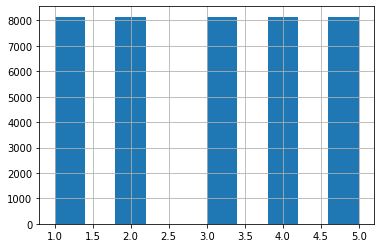

In [ ]:
# Dividing data in 5, equally
cleaned_up_data['exhaust_gas_temperature'] = pd.qcut(cleaned_up_data['EGT11'],
                                        q=5, 
                                        labels=[1, 2, 3, 4, 5])
cleaned_up_data['exhaust_gas_temperature'].hist()
cleaned_up_data['exhaust_gas_temperature'].value_counts()/len(cleaned_up_data)

In [ ]:
cleaned_up_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40740 entries, 167 to 83397
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   calLoad                  40740 non-null  float64 
 1   engSpeed                 40740 non-null  float64 
 2   vehSpeed                 40740 non-null  float64 
 3   intAirTemp               40740 non-null  float64 
 4   MAF                      40740 non-null  float64 
 5   absTPS                   40740 non-null  float64 
 6   fuelrailPress            40740 non-null  float64 
 7   baroPress                40740 non-null  float64 
 8   catTemp                  40740 non-null  float64 
 9   voltage                  40740 non-null  float64 
 10  ambTemp                  40740 non-null  float64 
 11  fuelInjTiming            40740 non-null  float64 
 12  fuelRate                 40740 non-null  float64 
 13  actEngPerTorque          40740 non-null  float64 
 14  MAFS

In [ ]:
cleaned_up_data.head()

,calLoad,engSpeed,vehSpeed,intAirTemp,MAF,absTPS,fuelrailPress,baroPress,catTemp,voltage,ambTemp,fuelInjTiming,fuelRate,actEngPerTorque,MAFSensor,compressorInletTemp,EGT11,EGT12,NOxRawSensor1_2,O2RawSensor1_2,exhFlowrate,CO2FlowRate,NOxFlowRateValidTail,slope_engSpeed,slope_O2,slope_MAF,slope_actEngPerTorque,slope_fuelRate,slope_exhFlowrate,exhaust_gas_temperature
167,21.032765,801.918230,0.0,24.0,5.957845,0.760220,33282.76813,100.0,-0.2,12.069534,51.0,0.933942,0.743115,17.798702,6.280131,29.707626,32.055511,27.063137,0.578388,121.061439,6.126285,1922.587648,0.000007,274.424851,2.120338,2.700041,-13.798702,0.380370,2.786258,2
168,46.690264,1076.343081,0.0,24.0,8.657886,1.176471,40420.74902,100.0,-0.2,12.009394,51.0,1.561315,1.123485,4.000000,8.475869,28.469704,35.309066,27.700000,0.701503,123.181776,8.912543,2906.680905,0.000035,-187.283575,63.735750,-0.991028,0.828810,-0.044205,-1.001048,2
169,56.615518,889.059506,0.0,24.0,7.666858,1.013959,29929.02938,100.0,-0.2,12.041440,51.0,1.719101,1.079280,4.828810,7.245498,27.585595,37.828810,26.954071,2.453131,186.917526,7.911495,2792.312577,0.000114,-55.574367,88.172071,-0.622230,1.171190,-0.029280,-0.628866,2
170,53.058259,833.485138,0.0,24.0,7.044628,0.784314,28670.00000,100.0,-0.2,12.094030,51.0,1.796875,1.050000,6.000000,6.997200,27.000000,39.000000,25.900000,9.113546,275.089597,7.282628,2716.560000,0.000253,7.380107,2.536307,0.124237,-0.182623,-0.009131,0.122167,2
171,52.903651,840.865246,0.0,24.0,7.168866,0.784314,29307.35340,100.0,-0.2,12.069043,51.0,1.796875,1.040869,5.817377,6.855164,27.000000,39.346983,25.900000,21.910459,277.625904,7.404796,2692.935921,0.000272,1.134267,-10.092051,-0.238208,-0.817377,-0.040869,-0.247472,2


In [ ]:
print(len(cleaned_up_data))
reindexed_data = cleaned_up_data.reset_index(drop=True)
print(len(reindexed_data))
reindexed_data['exhaust_gas_temperature'].value_counts()/len(reindexed_data)

40740
40740


5    0.2
4    0.2
3    0.2
2    0.2
1    0.2
Name: exhaust_gas_temperature, dtype: float64

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_validation_index, test_index in split.split(reindexed_data, reindexed_data['exhaust_gas_temperature']):
    train_validation_set = reindexed_data.loc[reindexed_data.index.intersection(train_validation_index),:]
    test_set = reindexed_data.loc[reindexed_data.index.intersection(test_index),:]

In [ ]:
len(train_validation_set)

32592

In [ ]:
len(test_set)

8148

In [ ]:
reindexed_train_validation_set = train_validation_set.reset_index(drop=True)
print(len(reindexed_train_validation_set))

32592


In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, validation_index in split.split(reindexed_train_validation_set, reindexed_train_validation_set['exhaust_gas_temperature']):
    train_set = reindexed_train_validation_set.loc[reindexed_train_validation_set.index.intersection(train_index),:]
    validation_set = reindexed_train_validation_set.loc[reindexed_train_validation_set.index.intersection(validation_index),:]

In [ ]:
X_train = train_set
y_train = pd.concat([X_train.pop(x) for x in label], axis=1)

X_valid = validation_set
y_valid = pd.concat([X_valid.pop(x) for x in label], axis=1)

X_test = test_set
y_test = pd.concat([X_test.pop(x) for x in label], axis=1)

In [ ]:
for set_ in (train_set, validation_set, test_set):
    set_.drop("exhaust_gas_temperature", axis=1, inplace=True)

In [ ]:
print(X_train.keys())

Index(['calLoad', 'engSpeed', 'vehSpeed', 'intAirTemp', 'MAF', 'absTPS',
       'fuelrailPress', 'baroPress', 'catTemp', 'voltage', 'ambTemp',
       'fuelInjTiming', 'fuelRate', 'actEngPerTorque', 'MAFSensor',
       'compressorInletTemp', 'EGT11', 'EGT12', 'O2RawSensor1_2',
       'exhFlowrate', 'CO2FlowRate', 'slope_engSpeed', 'slope_O2', 'slope_MAF',
       'slope_actEngPerTorque', 'slope_fuelRate', 'slope_exhFlowrate'],
      dtype='object')


In [ ]:
print(y_train.keys())

Index(['NOxFlowRateValidTail'], dtype='object')


In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[X_train.shape[1]]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
mean_vec = X_train.mean()
std_vec = X_train.std()
print(mean_vec)
print(std_vec)

mean_train = y_train['NOxFlowRateValidTail'].mean()
std_train = y_train['NOxFlowRateValidTail'].std()

mean_valid = y_valid['NOxFlowRateValidTail'].mean()
std_valid = y_valid['NOxFlowRateValidTail'].std()

mean_test = y_test['NOxFlowRateValidTail'].mean()
std_test = y_test['NOxFlowRateValidTail'].std()

#use json
mean_data = [dict(mean_vec)]
std_data = [dict(std_vec)]

import json
with open('mean_data_w_20_RDEs_only.json', 'w') as f:
    json.dump(mean_data,f)
    
with open('std_data_w_20_RDEs_only.json', 'w') as f:
    json.dump(std_data,f)

calLoad                     46.816234
engSpeed                  1413.584392
vehSpeed                    59.455626
intAirTemp                  13.822733
MAF                         23.489768
absTPS                       3.404635
fuelrailPress            65264.553264
baroPress                  101.101379
catTemp                     -0.200000
voltage                     14.173381
ambTemp                     51.167035
fuelInjTiming                2.145792
fuelRate                     4.075391
actEngPerTorque             17.327500
MAFSensor                   23.414917
compressorInletTemp         14.151130
EGT11                      294.811139
EGT12                      315.151125
O2RawSensor1_2             527.019311
exhFlowrate                 24.413523
CO2FlowRate              10543.851884
slope_engSpeed              -4.669611
slope_O2                    -9.266133
slope_MAF                   -0.216181
slope_actEngPerTorque       -0.186438
slope_fuelRate              -0.058944
slope_exhFlo

In [ ]:
# normalization
X_train = (X_train - mean_vec) / std_vec
y_train['NOxFlowRateValidTail'] = (y_train['NOxFlowRateValidTail'] - mean_train) / std_train

X_valid = (X_valid - mean_vec) / std_vec
y_valid['NOxFlowRateValidTail'] = (y_valid['NOxFlowRateValidTail'] - mean_valid) / std_valid

X_test = (X_test - mean_vec) / std_vec
y_test['NOxFlowRateValidTail'] = (y_test['NOxFlowRateValidTail'] - mean_test) / std_test

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
import time

start = time.time()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
param_distribs = {
    "n_hidden": [2, 3, 4, 5, 6, 7],
    "n_neurons": [128, 256, 512, 1024, 2048, 4096], ## 32~512 32 간격/2^n
    "learning_rate": [5e-3, 5e-4, 5e-5]
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_params_

In [ ]:
 model = rnd_search_cv.best_estimator_.model

 model.compile(optimizer='rmsprop',
             loss='mse',
             metrics=['mse'])

model.summary()

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(2048, activation='relu'),
#     tf.keras.layers.Dense(4096, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(4096, activation='relu'),
#     tf.keras.layers.Dense(4096, activation='relu'),
#     tf.keras.layers.Dense(4096, activation='relu'),
#     tf.keras.layers.Dense(len(label))
# ])

# model.compile(optimizer='rmsprop',
#              loss='mse',
#              metrics=['mse'])

# model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 2048)              57344     
                                                                 
 dense_15 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_16 (Dense)            (None, 4096)              8392704   
                                                                 
 batch_normalization_2 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_18 (Dense)            (None, 4096)              16781312  
                                                      

In [ ]:
import time

start = time.time()

In [ ]:
history = model.fit(X_train, y_train, epochs=300, batch_size=512, validation_data=(X_valid, y_valid))

Epoch 1/300
51/51 [==============================] - 9s 151ms/step - loss: 1015063.7500 - mse: 1015063.7500 - val_loss: 54.4530 - val_mse: 54.4530
Epoch 2/300
51/51 [==============================] - 7s 144ms/step - loss: 28.6790 - mse: 28.6790 - val_loss: 48.1759 - val_mse: 48.1759
Epoch 3/300
51/51 [==============================] - 7s 143ms/step - loss: 7.5057 - mse: 7.5057 - val_loss: 5.0746 - val_mse: 5.0746
Epoch 4/300
51/51 [==============================] - 7s 142ms/step - loss: 924.5556 - mse: 924.5556 - val_loss: 3.6822 - val_mse: 3.6822
Epoch 5/300
51/51 [==============================] - 7s 142ms/step - loss: 1.2223 - mse: 1.2223 - val_loss: 2.6962 - val_mse: 2.6962
Epoch 6/300
51/51 [==============================] - 7s 142ms/step - loss: 1.4960 - mse: 1.4960 - val_loss: 0.7599 - val_mse: 0.7599
Epoch 7/300
51/51 [==============================] - 7s 142ms/step - loss: 1.1741 - mse: 1.1741 - val_loss: 0.7898 - val_mse: 0.7898
Epoch 8/300
51/51 [============================

In [ ]:
print("계산시간 :", time.time() - start)

In [ ]:
loss = history.history['loss']
mse = history.history['mse']
val_loss = history.history['val_loss']
val_mse = history.history['val_mse']

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_train)

In [ ]:
plt.plot(y_pred, y_train, 'o')
x = np.arange(-1,21)
y = x
plt.plot(x, y, 'k')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_pred, y_train))

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
plt.plot(y_pred_test, y_test, 'o')
x = np.arange(-1,15)
y = x
plt.plot(x, y, 'k')
plt.show()

In [ ]:
print(r2_score(y_pred_test, y_test))  

In [ ]:
model.save('NOx_Prediction_model')

In [ ]:
new_model = tf.keras.models.load_model('NOx_Prediction_model')

# Check its architecture
new_model.summary()